In [1]:
import pickle

from scipy.stats import norm
from scipy.stats import iqr

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
SEED = 428
SIZE = 20

SMC_STEPS = 10000
MET_STEPS = 10000

[mu]
[mu]


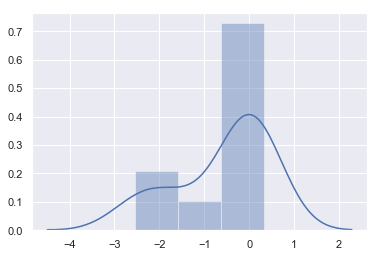

In [3]:
rnd = np.random.RandomState(SEED)
x = rnd.normal(loc=0, scale=1, size=10)
sns.distplot(x)

with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=3, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_1.vars)

with pm.Model() as model_2:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_2.vars)

# Sequential Monte Carlo

Sample initial stage: ...
Stage: 0 Beta: 0.034 Steps: 25
Stage: 1 Beta: 0.090 Steps: 4
Stage: 2 Beta: 0.193 Steps: 3
Stage: 3 Beta: 0.417 Steps: 4
Stage: 4 Beta: 1.000 Steps: 3


Log10 marginal likelihood: -9.20355


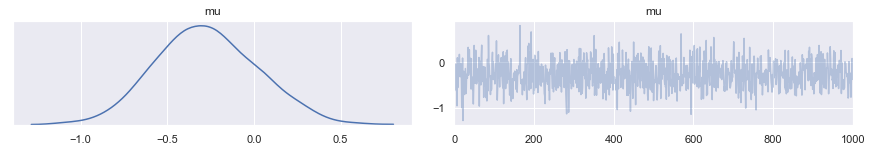

In [4]:
with model_1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_1.marginal_likelihood)))

Sample initial stage: ...
Stage: 0 Beta: 0.465 Steps: 25
Stage: 1 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -6.70467


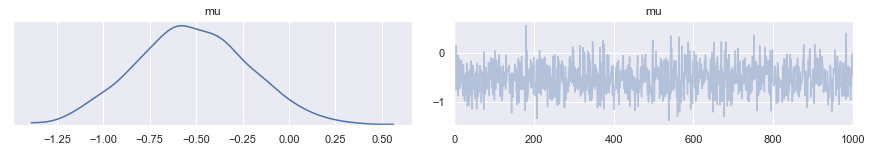

In [5]:
with model_2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_2.marginal_likelihood)) )

In [6]:
print("Log10 of Bayes factor model 2 over model 1: %0.5f" %(np.log10(model_2.marginal_likelihood) - 
      np.log10(model_1.marginal_likelihood)))

Log10 of Bayes factor model 2 over model 1: 2.49888
